## Notebook demonstrating the importing of terrain layers from SRTM or 3DEP datasets for any given region in the contiguous US using ssrs package

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from ssrs import Terrain, TurbinesUSWTB
from ssrs.raster import transform_bounds, transform_coordinates, get_raster_in_projected_crs
from ssrs.utils import get_extent_from_bounds, create_gis_axis

In [4]:
# directory where output is saved
output_dir = os.path.join(os.path.abspath(os.path.curdir), 'output/')

In [13]:
# Parameters for determining the region of interest
proj_crs = 'ESRI:102008' # projected crs
lonlat_crs = 'EPSG:4326' # geo crs
southwest_lonlat = (-79.7, 39.0) # southwestern point
region_width_km = (70., 60.) # region size in km
resolution = 100. # resolution in meters

In [14]:
# figure out the grid size of the target region
xsize = int(round((region_width_km[0] * 1000. / resolution)))
ysize = int(round((region_width_km[1] * 1000. / resolution)))
gridsize = (ysize, xsize)

In [15]:
# get the bounds of the revion in both lonlat and projected crs
proj_west, proj_south = transform_coordinates(lonlat_crs, proj_crs, southwest_lonlat[0], southwest_lonlat[1])
proj_east = proj_west[0] + xsize * resolution
proj_north = proj_south[0] + ysize * resolution
bounds = (proj_west[0], proj_south[0], proj_east, proj_north)
extent = get_extent_from_bounds(bounds)
lonlat_bounds = transform_bounds(bounds, proj_crs, lonlat_crs)

In [16]:
#Valid terrain layers
Terrain.valid_layers

('DEM',
 'Hillshade Gray',
 'Aspect Degrees',
 'Aspect Map',
 'GreyHillshade_elevationFill',
 'Hillshade Multidirectional',
 'Slope Map',
 'Slope Degrees',
 'Hillshade Elevation Tinted',
 'Height Ellipsoidal',
 'Contour 25',
 'Contour Smoothed 25',
 'SRTM1',
 'SRTM3')

In [17]:
# downloading terrain layers
terrain_layers = {
    'Elevation': 'DEM',
    'Slope': 'Slope Degrees',
    'Aspect': 'Aspect Degrees'
}
region = Terrain(lonlat_bounds, output_dir)
region.download(terrain_layers.values())

Terrain: Bounds set to [-79.7, 38.9, -78.72, 39.5]
Terrain: Downloading DEM data from 3DEP..
WMS: Downloading data for 24 tiles..
Terrain: Downloading Slope Degrees data from 3DEP..
WMS: Downloading data for 24 tiles..
Terrain: Downloading Aspect Degrees data from 3DEP..
WMS: Downloading data for 24 tiles..


In [18]:
def get_terrain_layer(lyr:str):
    fpath = region.get_raster_fpath(lyr)
    return get_raster_in_projected_crs(fpath, bounds, gridsize, resolution, proj_crs)

In [19]:
# get all the wind turbines in this region
turbines = TurbinesUSWTB(bounds, proj_crs, min_hubheight=60.)
turb_xlocs, turb_ylocs = turbines.get_locations()
turbines.print_details()

TurbinesUSWTB: Importing turbine data from USWTB..
TurbinesUSWTB: Minimum hub height set to 60.0 m
Number of projects: 9
Number of turbines: 302
Hub height (min,median,max): 70.0, 78.0, 100.0
Rotor Dia (min,median,max): 72.0, 80.0, 100.0
    Project                   State Year  Count Hub_Hght  Rotor_Dia 
1.  Fair Wind                 MD    2015  12    100.0     100.0     
2.  New Creek Wind            WV    2016  49    78.0      97.0      
3.  Criterion                 MD    2010  28    80.0      96.0      
4.  Pinnacle                  WV    2012  17    80.0      95.0      
5.  Roth Rock                 MD    2011  20    80.0      90.0      
6.  NedPower Mount Storm, Ph  WV    2008  83    78.0      80.0      
7.  NedPower Mount Storm, Ph  WV    2008  47    78.0      80.0      
8.  Mount Storm, Phase I      WV    2008  2     78.0      80.0      
9.  Mountaineer Wind Energy   WV    2002  44    70.0      72.0      


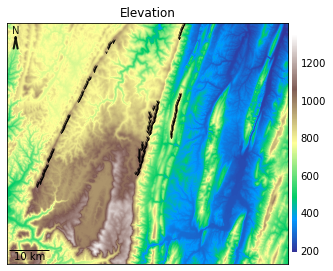

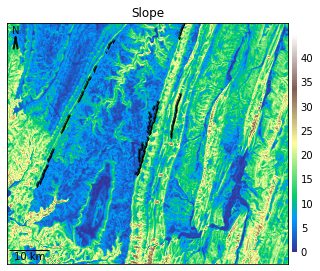

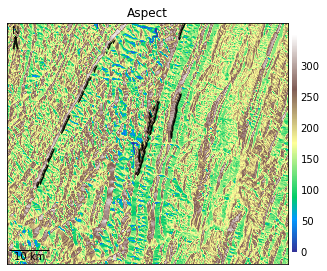

In [20]:
# plot all the layers
for key, val in terrain_layers.items():
    lyr_data = get_terrain_layer(val)
    fig, ax = plt.subplots(figsize=(6,5))
    cm = ax.imshow(lyr_data, cmap='terrain', extent=extent, origin='lower')
    create_gis_axis(fig, ax, cm)
    ax.plot(turb_xlocs, turb_ylocs, '1k', alpha=0.75, markersize=3.)
    ax.set_title(key)